In [1]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

fakebackend = FakeSherbrooke()

Counts: {'100': 184, '010': 172, '001': 156, '101': 186, '110': 169, '011': 120, '000': 23, '111': 14}


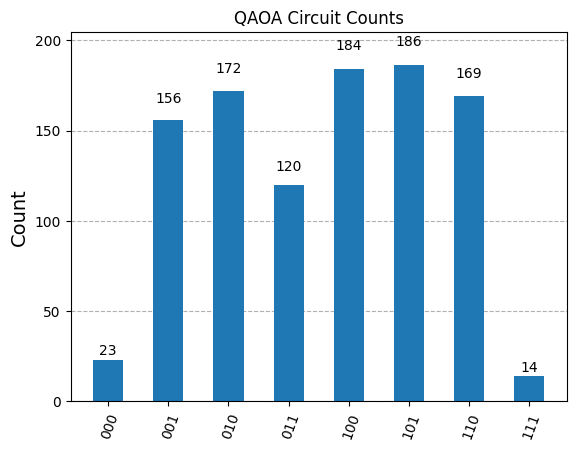

In [2]:
from mqt.bench import get_benchmark
from qiskit_ibm_runtime import SamplerV2
from qiskit import transpile
from qiskit.visualization import plot_histogram

qc_algorithmic_level1 = get_benchmark(benchmark_name="qaoa", level="alg", circuit_size=3)
qc_algorithmic_level1.draw(output="mpl")

transpiled_circuit1 = transpile(qc_algorithmic_level1, backend=fakebackend, optimization_level=1)
job = SamplerV2(fakebackend).run([transpiled_circuit1], shots=1024)
sim_result = job.result()[0]
sim_counts = sim_result.data.meas.get_counts()
print("Counts:", sim_counts)
plot_histogram(sim_counts, title="QAOA Circuit Counts")

Counts: {'00': 510, '11': 489, '10': 17, '01': 8}


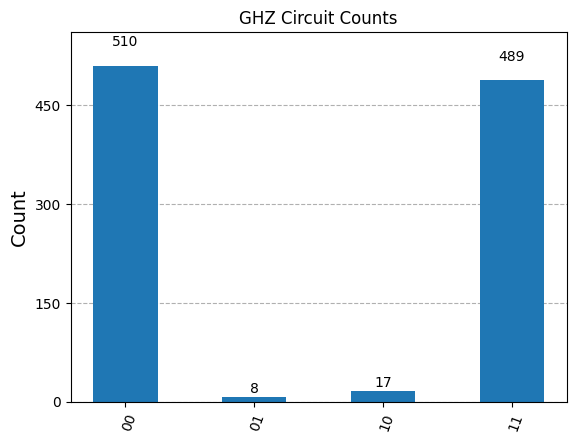

In [66]:
from mqt.bench import get_benchmark
from qiskit_ibm_runtime import SamplerV2
from qiskit import transpile
from qiskit.visualization import plot_histogram

qc_algorithmic_level2 = get_benchmark(benchmark_name="ghz", level="alg", circuit_size=2)
qc_algorithmic_level2.draw(output="mpl")

transpiled_circuit2 = transpile(qc_algorithmic_level2, backend=fakebackend, optimization_level=1)
job = SamplerV2(fakebackend).run([transpiled_circuit2], shots=1024)
sim_result = job.result()[0]
sim_counts = sim_result.data.meas.get_counts()
print("Counts:", sim_counts)
plot_histogram(sim_counts, title="GHZ Circuit Counts")

Counts: {'11': 507, '00': 517}


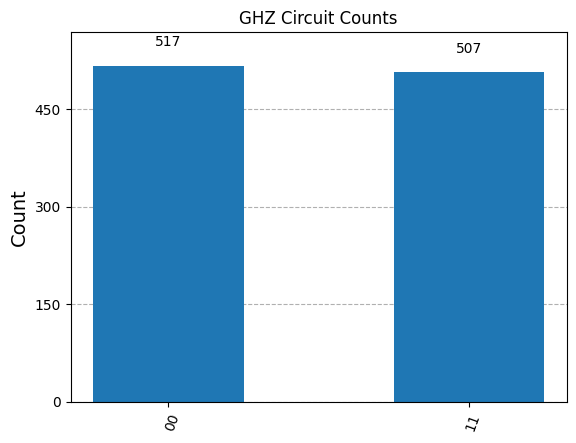

In [4]:
from qiskit_aer import AerSimulator
aer_simulator = AerSimulator()

qc_algorithmic_level2 = get_benchmark(benchmark_name="ghz", level="alg", circuit_size=2)
qc_algorithmic_level2.draw(output="mpl")

transpiled_circuit2 = transpile(qc_algorithmic_level2, backend=aer_simulator, optimization_level=1)
job = SamplerV2(aer_simulator).run([transpiled_circuit2], shots=1024)
sim_result = job.result()[0]
sim_counts = sim_result.data.meas.get_counts()
print("Counts:", sim_counts)
plot_histogram(sim_counts, title="GHZ Circuit Counts")

SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=5>)), metadata={'shots': 1024, 'circuit_metadata': {}})
Counts: {'11111': 15, '00111': 74, '11000': 76, '01100': 82, '10111': 82, '00100': 71, '01011': 81, '10100': 76, '11011': 67, '01111': 75, '01000': 93, '10000': 82, '00011': 9, '01001': 3, '00000': 14, '10011': 96, '11100': 14, '11010': 1, '01101': 1, '00101': 2, '01110': 1, '10101': 1, '10110': 1, '10010': 3, '00110': 3, '01010': 1}


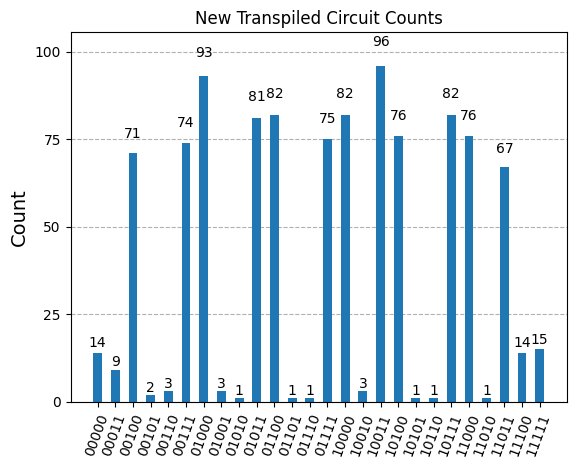

In [67]:
from component.c_circuit_work.knitting.width_k import expand_circuit_width

qc_algorithmic_level1.remove_final_measurements()
qc_algorithmic_level2.remove_final_measurements()


new_transpile_circuit = expand_circuit_width(qc_algorithmic_level1, qc_algorithmic_level2)
new_transpile_circuit.draw(output="mpl")
new_transpile_circuit.measure_all()
new_transpile_circuit.draw(output="mpl")

transpiled_circuit = transpile(new_transpile_circuit, backend=fakebackend, optimization_level=1)
job = SamplerV2(fakebackend).run([transpiled_circuit], shots=1024)
sim_result = job.result()[0]
print(sim_result)  # SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=4>)), metadata={'shots': 1024, 'circuit_metadata': {}})
sim_counts = sim_result.data.meas.get_counts()
print("Counts:", sim_counts)
plot_histogram(sim_counts, title="New Transpiled Circuit Counts")

In [68]:
count1 = {}
count2 = {}

for key, value in sim_counts.items():
    count1_key = key[:3]  # First 3 bits
    count2_key = key[-2:]  # Last 2 bits

    count1[count1_key] = count1.get(count1_key, 0) + value
    count2[count2_key] = count2.get(count2_key, 0) + value

print("Count1:", count1)
print("Count2:", count2)

Count1: {'111': 29, '001': 150, '110': 144, '011': 159, '101': 160, '010': 178, '100': 181, '000': 23}
Count2: {'11': 499, '00': 508, '01': 7, '10': 10}


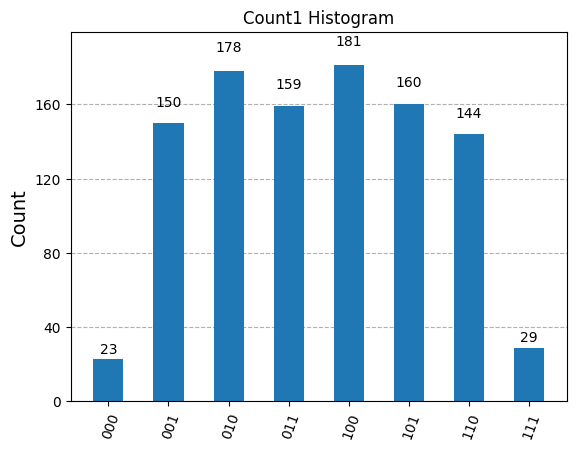

In [69]:
plot_histogram(count1, title="Count1 Histogram")

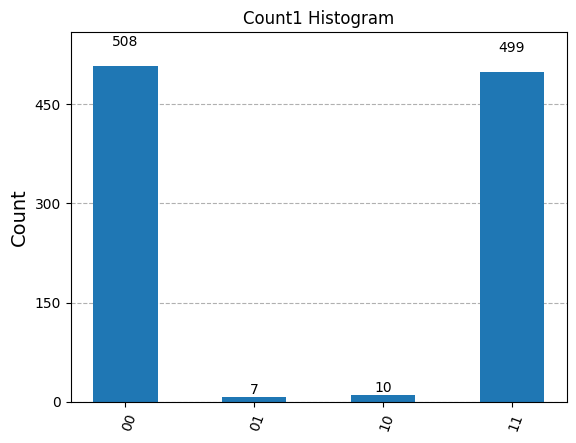

In [70]:
plot_histogram(count2, title="Count1 Histogram")

In [63]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

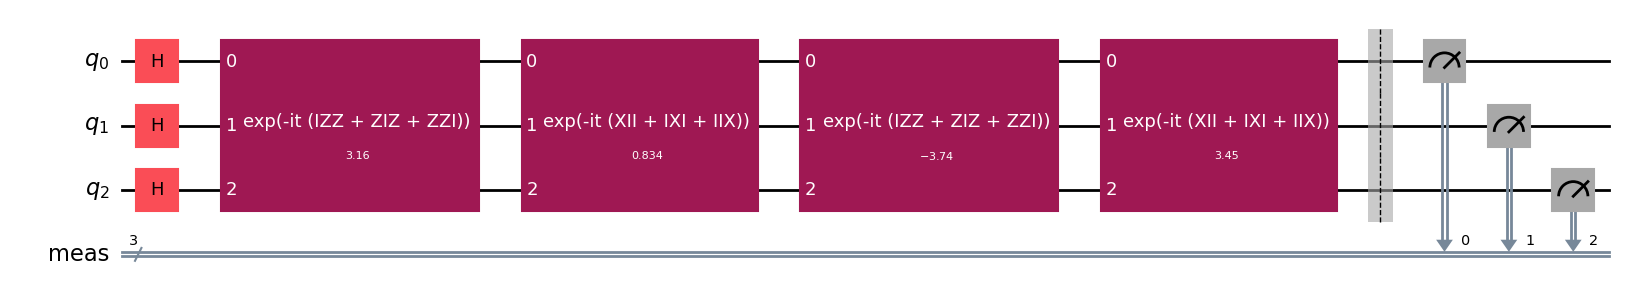

In [71]:
from mqt.bench import get_benchmark

import numpy as np

qc_algorithmic_level1 = get_benchmark(benchmark_name="qaoa", level="alg", circuit_size=3)
qc_algorithmic_level1.draw(output="mpl")


In [72]:
from qiskit.transpiler import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc_algorithmic_level1)
print(f">>> Circuit ops (ISA): {isa_circuit.count_ops()}")

>>> Circuit ops (ISA): OrderedDict([('rz', 50), ('sx', 38), ('ecr', 18), ('x', 6), ('measure', 3), ('barrier', 1)])


In [73]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
sampler = Sampler(mode=backend)

In [74]:
job = sampler.run([(isa_circuit)])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d0493bdrxz8g0087xd40
>>> Job Status: QUEUED


In [75]:
result = job.result()
 
# Get results for the first (and only) PUB
pub_result = result[0]
print(
    f"Counts for the 'meas' output register: {pub_result.data.meas.get_counts()}"
)

Counts for the 'meas' output register: {'101': 749, '110': 525, '100': 1010, '010': 532, '011': 417, '001': 749, '111': 60, '000': 54}


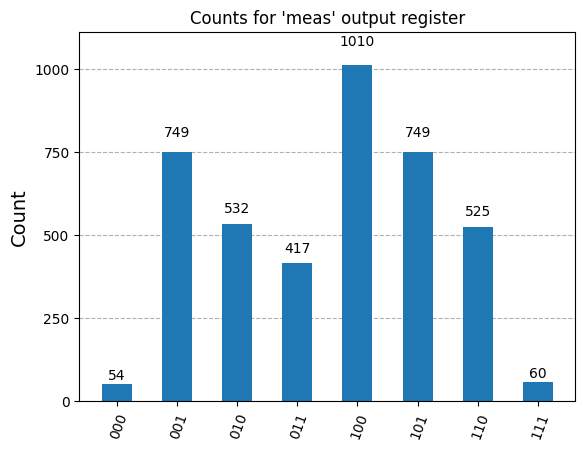

In [76]:
from qiskit.visualization import plot_histogram

plot_histogram(pub_result.data.meas.get_counts(), title="Counts for 'meas' output register")

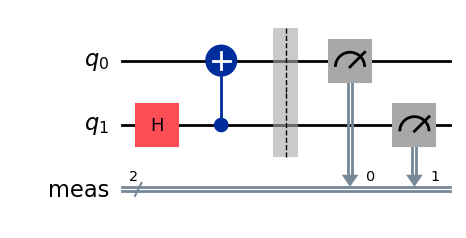

In [ ]:
qc_algorithmic_level2 = get_benchmark(benchmark_name="ghz", level="alg", circuit_size=2)
qc_algorithmic_level2.draw(output="mpl")

In [78]:
from qiskit.transpiler import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1, backend=fakebackend)
isa_circuit = pm.run(qc_algorithmic_level2)
print(f">>> Circuit ops (ISA): {isa_circuit.count_ops()}")

>>> Circuit ops (ISA): OrderedDict([('rz', 3), ('sx', 2), ('measure', 2), ('ecr', 1), ('x', 1), ('barrier', 1)])


In [79]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
sampler = Sampler(mode=backend)

In [80]:
job0 = sampler.run([(isa_circuit)])
print(f">>> Job ID: {job0.job_id()}")
print(f">>> Job Status: {job0.status()}")

>>> Job ID: d0494ktkzhn0008w3yt0
>>> Job Status: QUEUED


In [81]:
result0 = job0.result()
 
# Get results for the first (and only) PUB
pub_result0 = result0[0]
print(
    f"Counts for the 'meas' output register: {pub_result0.data.meas.get_counts()}"
)

Counts for the 'meas' output register: {'01': 72, '11': 2049, '00': 1858, '10': 117}


In [82]:
counts = pub_result0.data.meas.get_counts()

print(counts)


{'01': 72, '11': 2049, '00': 1858, '10': 117}


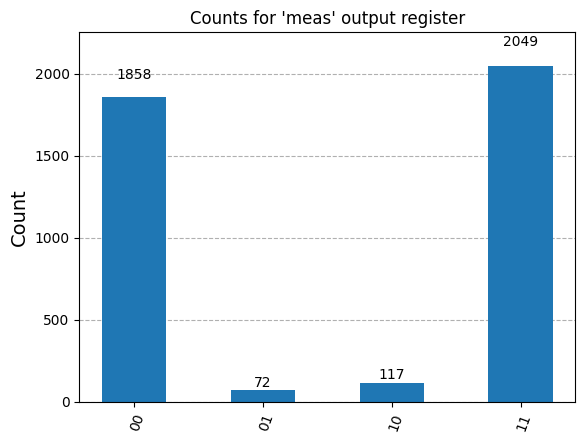

In [83]:
plot_histogram(counts, title="Counts for 'meas' output register")

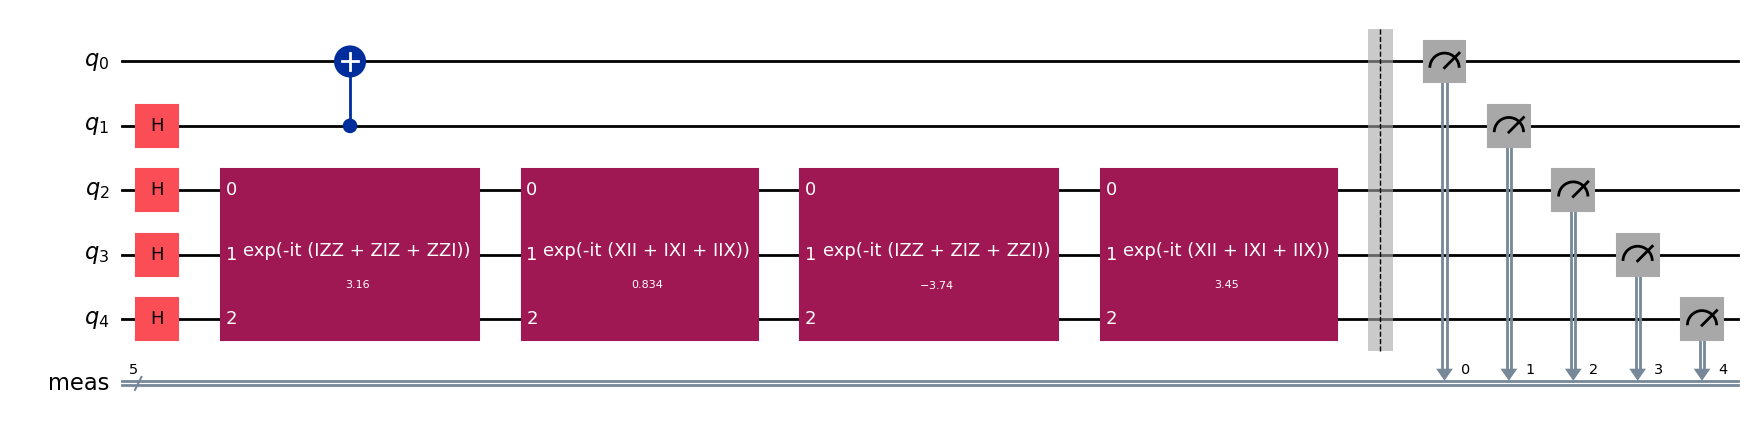

In [ ]:
qc_algorithmic_level1.remove_final_measurements()
qc_algorithmic_level2.remove_final_measurements()


new_transpile_circuit = expand_circuit_width(qc_algorithmic_level1, qc_algorithmic_level2)
new_transpile_circuit.draw(output="mpl")
new_transpile_circuit.measure_all()
new_transpile_circuit.draw(output="mpl")

In [85]:
from qiskit.transpiler import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1, backend=fakebackend)
isa_circuit = pm.run(new_transpile_circuit)
print(f">>> Circuit ops (ISA): {isa_circuit.count_ops()}")

>>> Circuit ops (ISA): OrderedDict([('rz', 53), ('sx', 40), ('ecr', 19), ('x', 7), ('measure', 5), ('barrier', 1)])


In [86]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
sampler = Sampler(mode=backend)

In [87]:
job3 = sampler.run([(isa_circuit)])
print(f">>> Job ID: {job3.job_id()}")
print(f">>> Job Status: {job3.status()}")

>>> Job ID: d04963g6rr3g008dvvh0
>>> Job Status: QUEUED


In [90]:
result3 = job3.result()
 
# Get results for the first (and only) PUB
pub_result3 = result3[0]
print(
    f"Counts for the 'meas' output register: {pub_result3.data.meas.get_counts()}"
)
count3 = pub_result3.data.meas.get_counts()

Counts for the 'meas' output register: {'00010': 5, '10111': 321, '10000': 380, '11111': 68, '11000': 229, '01111': 257, '10011': 382, '10100': 382, '10101': 25, '01011': 259, '00101': 32, '10001': 40, '01000': 240, '11011': 227, '11100': 57, '00111': 307, '01100': 279, '01101': 29, '11101': 6, '00100': 341, '11001': 17, '01001': 22, '00011': 25, '00000': 35, '10010': 29, '01110': 23, '00110': 26, '01010': 17, '11010': 12, '10110': 18, '11110': 5, '00001': 1}


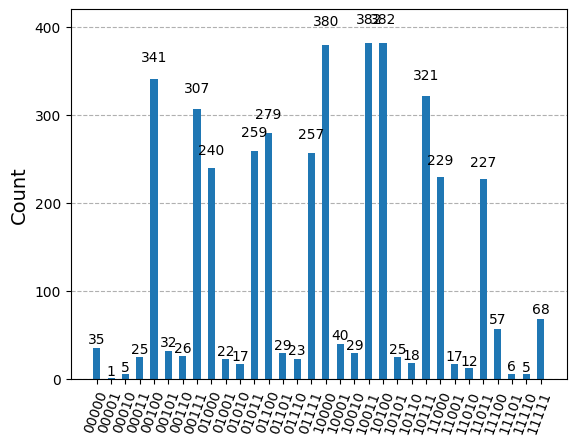

In [108]:
plot_histogram(count3)

In [106]:
count1de = {}
count2de = {}

for key, value in sim_counts.items():
    count1_key = key[:3]  # First 3 bits
    count2_key = key[-2:]  # Last 2 bits

    count1de[count1_key] = count1de.get(count1_key, 0) + value
    count2de[count2_key] = count2de.get(count2_key, 0) + value

print("Count1:", count1de)
print("Count2:", count2de)

Count1: {'111': 29, '001': 150, '110': 144, '011': 159, '101': 160, '010': 178, '100': 181, '000': 23}
Count2: {'11': 499, '00': 508, '01': 7, '10': 10}


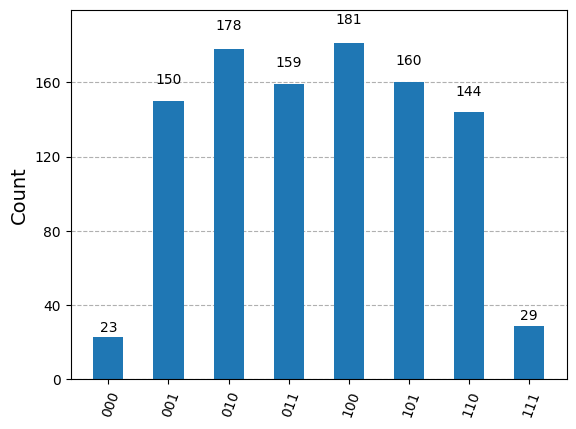

In [107]:
plot_histogram(count1de)

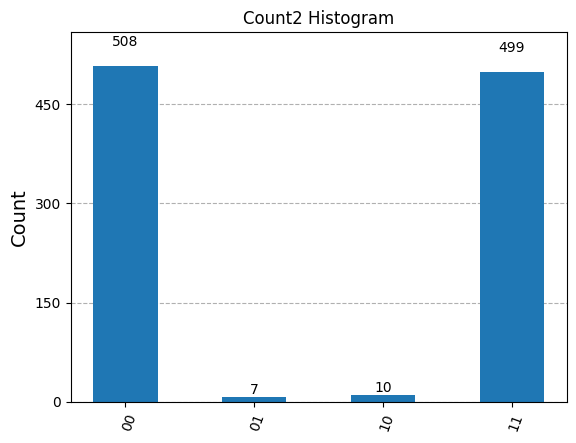

In [109]:
plot_histogram(count2de, title="Count2 Histogram")